<a href="https://colab.research.google.com/github/lk-learner/AMII-Machine-Learning-Technician-1/blob/main/Team2_Capstone_Project_Data_All_QuAMs_Lakshmi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMII - Machine Learning Technician  Capstone Project
Friday, December 11, 2020

Team 2


# Jet Engine Automatic Risk Assessment and Estimating Remaining Useful Life From Sensor Data
https://www.kaggle.com/behrad3d/nasa-cmaps





# Problem Scoping: Backward Process

</br>
<font color ='blue'>3a) Describe the outcome(s) you hope to achieve. List all outcomes, narrow the list, then aim for one. Keep track of the initial brainstorm as this may serve you as you iterate on your problem scoping.
 





We determined the following possible business outcomes for this dataset. The one in bold is the outcome we have chosen to pursue.

1. Eliminate plane crashes due to engine failures.
**2. Maximize the operating lifetime of the engine.**
3. Determine when the engine is not optimally operating.
4. Determine if a fault is system critical or can be addressed later
5. Determine number of cycles before failure occurs

</br>
<font color ='blue'>
3b) Approximate the performance, time and cost of how this task might currently be done at a company. Remember, this is a back of the napkin calculation.

Traditional prognostics is completed by a engineering specialist or a team of specialists to calculate the desired outcome. This is tedious and lengthly to manually process all of this data, and performance would be subjective based on the personnel doing the analysis, potentially leading to poor repeatablity, and costly in terms of salaries for specialized skills and equipment.

Another approach is use actual engines running to failure to collect physical data instead of simulation data. This is similar in performance, repeatability, and time as above but with an added cost of losing a working engine. It also has no control on the types of failure occuring during the test.

</br>
<font color ='blue'>3c) Identify which of the 5 Value Areas (Prevent, Project, Produce, Promote,
Personalize) your outcome is related to.



Prevention:
  All of our outcomes could be considered a prevention value area as we are preventing failure in system critical components.

  Outcome 3 and 5 fall under the Project Value Area as they are not actively preventing an undesirable outcome as they classify the state of the engine.

</br>
<font color ='blue'>3d) Describe the potential actions that will be performed to produce your outcome.


Potentinal Actions:

1. Compare cost of maintaining or repair vs replace.
2. Estimate the remaining life of the engine
3. Do preventative maintenance / plan inspection on the engine to extend the life.
4. Re-prioritize maintenance schedule based on remaining life.


</br>
<font color ='blue'>3e) Do a judgement analysis of when your QuAM produces a right and a wrong answer. List the potential consequences and potential corrective actions.



Risks:
False Positives - The engine fails before the remaining life predicted by the QuAM. This results is significant costs to equipment, reputation, and safety. Corrective action by retraining the QuAM on the new data from the engine failure.

</br>
<font color ='blue'>3f) List the question your QuAM will answer by specifying both the question template and question object. Verify that this aligns with your business outcome.


Question Template: Should the ____ be replaced?

Question Object: Engine

Question: Should the engine be replaced?


</br>
<font color ='blue'>3g) List the answers you expect your QuAM to produce. Verify that they align with the business outcome.

QuAM might produce following answers:

Yes, the engine should be replaced

No, continue to run as per maintenance schedule.


#Data Inspection and Data Analysis by Engine type

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import graphviz
import matplotlib.pyplot as plt

from google.colab import drive
from plotly.subplots import make_subplots
from sklearn.feature_selection import mutual_info
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge


The columns in the raw data have no headers but the included paper describing the data set provide a list of variables, listed below. The readme file in the data set did not specify the order of the sensors so it was assumed that it is the same order as the table below.

| Symbol | Description | Units |
| :-: | :- | :-: |
| Unit No. | Engine identification number | -- |
| Time in Cycles | Number of engine operating cycles | -- |
| Operation Setting 1 | Altitude | 0-42k ft |
| Operation Setting 2 | Mach Number | 0-0.84 |
| Operation Setting 3 | Throttle resolver angle | degrees |
| T2 | Total temperature at fan inlet | °R
| T24 | Total temperature at LPC outlet | °R |
| T30 | Total temperature at HPC outlet | °R |
| T50 | Total temperature at LPT outlet | °R |
| P2 | Pressure at fan inlet | psia |
| P15 | Total pressure in bypass-duct | psia |
| P30 | Total pressure at HPC outlet | psia |
| Nf | Physical fan speed | rpm |
| Nc | Physical core speed | rpm |
| epr | Engine pressure ratio (P50/P2) | -- | 
| Ps30 | Static pressure at HPC outlet | psia |
| phi | Ratio of fuel flow to Ps30 | pps/psi |
| NRf | Corrected fan speed | rpm |
| NRc | Corrected core speed | rpm |
| BPR | Bypass Ratio | -- |
| farB | Burner fuel-air ratio | -- |
| htBleed | Bleed Enthalpy  | -- | 
| Nf_dmd | Demanded fan speed | rpm |
| PCNfR_dmd | Demanded corrected fan speed | rpm |
| W31 | HPT coolant bleed | lbm/s |
| W32 | LPT coolant bleed | lbm/s |

##Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def Load_Engine_Training_Data(root_dir):
  
  #Load Training Data
  engine1 = pd.read_csv(root_dir + 'train_FD001.txt', sep=' ')
  engine2 = pd.read_csv(root_dir + 'train_FD002.txt', sep=' ')
  engine3 = pd.read_csv(root_dir + 'train_FD003.txt', sep=' ')
  engine4 = pd.read_csv(root_dir + 'train_FD004.txt', sep=' ')

  cols=['Unit_Number','Time_in_Cycles','OP_Setting_1','OP_Setting_2','OP_Setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
        'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

  engines = [engine1, engine2, engine3, engine4]

  for n, engine in enumerate(engines, start=1):
    raw_shape = engine.shape
    print(f'Engine {n} raw data shape: {raw_shape}.')
    engine.dropna(how='all', axis='columns', inplace= True)
    if engine.shape != raw_shape:
      print(f'Blank columns were dropped.')
    else:
      print(f'No columns were dropped.')
    engine.columns = cols
    engine['Engine_Type'] = n
    engines[n-1] = Calculate_RUL(engine)
    #print(f'Engine {n} Loaded shape = {engine.shape}.\n')

  all_engines = pd.concat(engines)
  print(f'Combined data shape: {all_engines.shape}.')
  return all_engines

In [ ]:
def Calculate_RUL(engine_dataframe):
  """ Calculate Remaining Useful life for the given engine data.
      Assumes that the dataframe has columns ['Unit_Number', 'Time_in_Cycles']"""
  
  print(f'Original dataset dimensions: {engine_dataframe.shape}')
  dataframe = engine_dataframe.copy()

  #Add a new column for the Time to Failure and RUL values
  lifetime_col = 'Engine_Lifetime'
  dataframe[lifetime_col] = 0

  #Group data by unit number and grab the maximum cycles for each unit as an array
  engine_lifetime = dataframe.groupby(['Unit_Number']).max()['Time_in_Cycles'].to_numpy()

  #Loop throught the engine_lifetimes array and assign the value to the Engine_Lifetime column for each unit
  for unit, lifetime in enumerate(engine_lifetime, start=1):
    is_unit = (dataframe.loc[:,'Unit_Number'] == unit)
    dataframe.loc[is_unit, lifetime_col] = lifetime

  #Calculate the RUL by taking the difference between engine lifetime and current time in cycles
  dataframe.loc[:,'RUL'] = dataframe.loc[:,lifetime_col] - dataframe.loc[:,'Time_in_Cycles']
  #print(f'Transformed dataset dimensions: {dataframe.shape}\n')
  
  return  dataframe

In [ ]:
#data_dir = '/content/drive/MyDrive/ML Technician Student Folder | Fall 2020/Teams/Team 2/Engine Data/'
data_dir = '/content/drive/MyDrive/archive/CMaps/'
engine_df = Load_Engine_Training_Data(data_dir)

Engine 1 raw data shape: (20630, 28).
Blank columns were dropped.
Original dataset dimensions: (20630, 27)
Engine 2 raw data shape: (53758, 28).
Blank columns were dropped.
Original dataset dimensions: (53758, 27)
Engine 3 raw data shape: (24719, 28).
Blank columns were dropped.
Original dataset dimensions: (24719, 27)
Engine 4 raw data shape: (61248, 28).
Blank columns were dropped.
Original dataset dimensions: (61248, 27)
Combined data shape: (160355, 29).


The engine variables are shown below superimposed on a two stage gas turbine engine diagram. The variables in blue are included in the project data files and the variables is red were used to determine the health indices which were then used to determine the usuable life of the engine.

<img src='https://drive.google.com/uc?id=1pB9a-CFuLQQES6AjwrSj2687FPmExO-i'>

In [ ]:
def Show_Scatter_Matrix(dataframe, features):
  fig = px.scatter_matrix(data_frame=dataframe, dimensions = features)
  fig.show()

In [ ]:
#Show_Scatter_Matrix(engine_df, ['T2','T24','T30','T50'])

There are a total of 6 combinations of operating conditions (listed below), and the bounds for each of the three variables are determined from the histograms above.

| Condition | Op_Setting_1 | Op_Setting_2 | Op_Setting_3 |
| :-: | :-: | :-: | :-: |
|1| -0.20 to  0.20|-0.005 to 0.004|100|
|2|  9.80 to 10.20| 0.245 to 0.254|100|
|3| 19.80 to 20.20| 0.695 to 0.704|100|
|4| 24.80 to 25.20| 0.615 to 0.624|60|
|5| 34.80 to 35.20| 0.835 to 0.844|100|
|6| 41.80 to 42.20| 0.835 to 0.844|100|

In [ ]:
def Calculate_Operating_Condition(Engine_Data, LimitsOP1, LimitsOP2, LimitsOP3):
  """
  This function will create three different boolean filters based on the supplied
  setting limits and return a combination filter

  Assumes that Engine_Data has columns called 'OP_Setting_1', 'OP_Setting_2', 
  'OP_Setting_3'

  Also, assumes the OP limits have two values = [lower limit, higher limit]
  """
#  print(LimitsOP1)
#  print(LimitsOP2)
#  print(LimitsOP3)
  
  OP1_values = Engine_Data['OP_Setting_1']
  within_OP1 = (OP1_values >= LimitsOP1[0]) & (OP1_values <= LimitsOP1[1])
  
  OP2_values = Engine_Data['OP_Setting_2']
  within_OP2 = (OP2_values >= LimitsOP2[0]) & (OP2_values <= LimitsOP2[1])
  
  OP3_values = Engine_Data['OP_Setting_3']
  within_OP3 = (OP3_values == LimitsOP3)
  
  filter = within_OP1 & within_OP2 & within_OP3

  print(f'OP1 values: {LimitsOP1}')
  print(f'OP2 values: {LimitsOP2}')
  print(f'OP3 values: {LimitsOP3}')
  print('----')
  return within_OP1 & within_OP2 & within_OP3

In [ ]:
def Set_Operating_Conditions(dataframe):
  
  data = dataframe.copy()
  OP_Condition = 'OP_Condition'
  Operating_Conditions = [1,2,3,4,5,6]

  OP_Setting1_limits = [[-0.2,0.2], [9.8, 10.2],
                [19.8, 20.2], [24.8, 25.2], 
                [34.8, 35.2], [41.8, 42.2]]

  OP_Setting2_limits = [[-0.005, 0.004], [0.245, 0.254],
                [0.695, 0.704], [0.615, 0.624],
                [0.835, 0.844], [0.835, 0.844]]

  OP_Setting3_limits = [100,100,100,60,100,100]

  data[OP_Condition] = 0

  for OP_Num, condition in enumerate(Operating_Conditions):
    print(f'Calculating Operating Condition {OP_Num + 1}.')
    condition_filter = Calculate_Operating_Condition(data, OP_Setting1_limits[OP_Num], OP_Setting2_limits[OP_Num], OP_Setting3_limits[OP_Num])

    data.loc[condition_filter, OP_Condition] = OP_Num + 1

  return data

There appears to be some negative values of OP Setting_2 (Mach number) into the engine. The physical meaning of this would be that the aircraft is flying backwards. These negative values are most likely due to noise in the velocity sensor and should be corrected before using the data in creating new features or QuAMs.

All of these negative values correspond to operating condition 1. Below is a histogram of the Mach number at operating condition 1 to visualize the distribution of values:

In [ ]:
def Remove_Negative_Machs(dataframe):
  OP_Setting_2 = 'OP_Setting_2'
  OP_Condition = 'OP_Condition'
  bad_machs = dataframe.loc[(dataframe.loc[:,OP_Setting_2] < 0),:].count()[OP_Setting_2]
  total_machs = dataframe.count()[OP_Setting_2]
  print(f'There are {bad_machs} out of {total_machs} Mach numbers,({100*bad_machs/total_machs:.1f}%), below zero')

  Mach_OP1 = dataframe.loc[(dataframe.loc[:,OP_Condition]==1),:]
  fig1 = px.histogram(Mach_OP1, x=OP_Setting_2)
  fig1.update_layout(height=300, margin=dict(l=0, r=0, t=1, b=0))
  fig1.show()

  Ma_less_than_0 = (dataframe.loc[:,OP_Setting_2] < 0)
  dataframe.loc[Ma_less_than_0, OP_Setting_2] = 0

  Mach_OP1 = dataframe.loc[(dataframe.loc[:,OP_Condition]==1),:]
  fig2 = px.histogram(Mach_OP1, x=OP_Setting_2)
  fig2.update_layout(height=300, margin=dict(l=0, r=0, t=1, b=0))
  fig2.show()

  return dataframe

Since the dominant value of Mach number in the data set is equal to zero, we will assume all of the negative values to be zero as well.

#Feature Engineering

Additional features are created to combine the available sensor and operation settings data into more relevent variables and to reduce the number of features used in the QuAMs. The features and constants are shown in yellow and blue, respectively, on the engine diagram below:

The type of features created are categorized into atmospheric, conservative, performance, and dimensional reduction features.

<img src='https://drive.google.com/uc?id=19TlXMPMZ4Wz00cgfZZEFBb5zvWGNncmE'>

##Atmospheric Features

Atmospheric features are derived from the operating settings and the physical properties of the atmosphere outside of the engine. The primary feature in this category is the mass flow rate of air entering the fan of the engine. To calculate this, we need the density of the air (rho), speed of sound at the inlet temperature (c), inlet air speed (v2), and the mass flow rate of air into the engine (mdot2). 

The atmosphere is assumed to be dry air modeled as an ideal gas with constant thermal properties. The variables that we need are calculated from the following equations:

\begin{align}
\rho_2 & = \frac{P_2}{R* T_2}\\
c & = \sqrt{ \gamma*R*T_2} \\
v_2 & = Ma * c \\
\dot{m_2} &= \rho_2 * v_2
\end{align}


Where R is the specific gas constant (equal to 53.35 ft-lbf / (lb-R)) and $\gamma$ is the heat capacity ratio (equal to 1.40) for air. 

In [ ]:
def Create_Atmospheric_Features(dataframe):
  #Atmospheric constants
  R = 53.35 #(ft-lbf) / (lb-R)
  g = 31.174 #ft/s^2
  gamma = 1.4

  atm_feature_names = ['rho2', 'v_sound', 'u2', 'mdot_2']

  P2 = dataframe['P2'] #psi
  T2 = dataframe['T2'] #R
  rho2 = P2 / (R + T2)  #lbm/ft3
  v_sound = np.sqrt(g * gamma * R * T2) #ft/s 
  u2= dataframe['OP_Setting_2'] * v_sound #ft/s
  mdot_2 = rho2 * u2 #lbm/s

  atm_features = pd.concat([rho2, v_sound, u2, mdot_2], axis=1)
  atm_features.columns = atm_feature_names
  print(f'Created atmospheric features: {atm_feature_names}')
  return atm_features

##Conservation Features

Mass flowing through the engine is always conserved. This allows us to use the mass flow into the engine and calculate flow properties throughout the engine. These can be viewed as simulated sensors in addition to the supplied sensors. 

A particular mass flow rate to be considered is the flow through the core, passing through the High Pressure Compressor (HPC) since this is the only engine component degrading in the supplied data set (as detailed in the accompanying report). The health index used to simulate failure in the HPC is directly related to the mass flow and efficiency of the compressor.  

\begin{align}
\dot{m_{fan}} &= \dot{m_2} * BPR \\
\dot{m_{core}} &= \dot{m_2} / BPR \\
\dot{W_F} &= \phi * P_s30
\end{align}

In [ ]:
def Create_Conservation_Features(dataframe, atm_data):
  conservation_feature_names = ['mdot_fan', 'mdot_core', 'Fuel_flow']

  mdot_fan = atm_data['mdot_2'] * dataframe['BPR'] #lbm/s
  mdot_core = atm_data['mdot_2'] / dataframe['BPR'] #lbm/s
  W_dot_F = dataframe['phi'] * dataframe['Ps30'] #lbm/s

  conservation_features = pd.concat([mdot_fan, mdot_core, W_dot_F], axis=1)
  conservation_features.columns = conservation_feature_names
  print(f'Created conservation of mass features: {conservation_feature_names}')
  return conservation_features

##Performance Features
To understand and quantify the performance of the components, we need to do a thermodynamic analysis of the air moving through engine. The thermodynamic cycle shown below, called the [Brayton Cycle](https://en.wikipedia.org/wiki/Brayton_cycle) represents the fundamental process of turbofan engines. The plots on the right show how the pressure, temperature, and entropy of the air changes as it moves through the engine core.

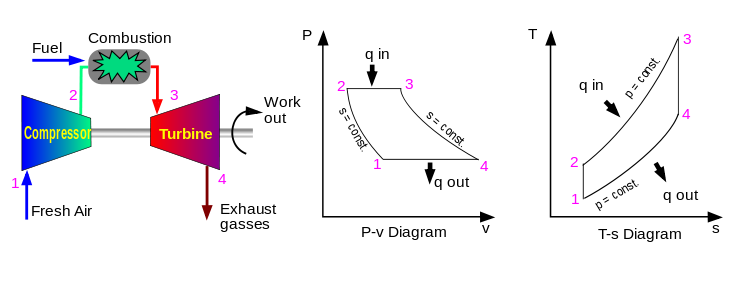

The efficiency of the HPC is a critical feature as it is directly related to the health index used to determine the remaining useful life of the engine. We assume adiabatic and reversible (also known as isentropic) processes. With this simplification we can estimate the efficieny using the temperatures at the inlet and outlet as per the equations below:

\begin{align}
\eta_{LPC} &= 1-\frac{T_2}{T_{24}} \\
\eta_{HPC} &= 1-\frac{T_{24}}{T_{30}} \\
\end{align}

In [ ]:
def Create_Performance_Features(dataframe):
  performance_features_names = ['eLPC', 'eHPC']

  eLPC = 1.0 - (dataframe['T2'] / dataframe['T24'])
  eHPC = 1.0 - (dataframe['T24'] / dataframe['T30'])

  performance_features = pd.concat([eLPC, eHPC], axis=1)
  performance_features.columns = performance_features_names
  print(f'Created engine performance features: {performance_features_names}')
  return performance_features

##Dimension Reduction Features

These features are created to reduce the feature space of the problem.

The fan speed and demanded fan speed can be combined into an fan speed error feature, as show below. As the demanded fan speed is a constant value, the distribution of the fan speed error should be directly proportional to the distribution of the fan speed.

\begin{align}
N^f_{error} &= N^f - N^f_{dmd}
\end{align}

In [ ]:
def Create_Reduction_Features(dataframe): 
  reduction_feature_name = ['Nf_err']

  Nf_err = np.abs(dataframe['Nf_dmd'] - dataframe['Nf'])
  print(f'Created dimensional reduction features: {reduction_feature_name}')
  reduction_feature = pd.DataFrame({'reduction_feature_name': Nf_err})

We can now combine all of the new features with the sensor data.

In [ ]:
def Create_Engine_Features(dataframe):

  atm_features = Create_Atmospheric_Features(dataframe)
  con_features = Create_Conservation_Features(dataframe, atm_features)
  per_features = Create_Performance_Features(dataframe)
  dim_features = Create_Reduction_Features(dataframe)

  dataframe2 = pd.concat([dataframe, atm_features, con_features, per_features, dim_features], axis = 1)
  print(f'New data from shape: {dataframe2.shape}')
  return dataframe2

#Risk Assessment

We need to group the engines into risk categories based on the remaining useful life (RUL) using the operational parameters and sensor data. 

These risk categories can be used to prioitize engine maintenance and prepare for replacement before the QuAM predicts engine failure. They can also be used as an administrative tool to focus monitoring of high risk engines.

The proposed risk categories are High, Medium, and Low and the RUL thresholds are determine by observing the histogram of RUL values. High risk engines were defined as engines in the lower quartile of the RUL data, medium risk engines were taken as engines with RUL values between the 25% and 75% quartile of the RUL values, and low risk engines were everything greater.

In [ ]:
def Classify_Engine_Risk(dataframe):
  
  dataframe2 = dataframe.copy()
  
  limits = dataframe2['RUL'].describe()

  high_risk = round(limits['25%'],1)
  low_risk = round(limits['75%'],1)
  med_risk = round(limits['mean'],1)
  risk_levels = {'High': high_risk, 'Medium': med_risk, 'Low': low_risk}
  print(f'Risk levels: {risk_levels}')
  
  fig1 = px.histogram(dataframe2, x='RUL', color='OP_Condition')
  fig1.show()

  Risk_category_name = 'Risk_Level'
  RUL_label = 'RUL'
  dataframe2[Risk_category_name] = "Risk Needed"
  RUL_Series = dataframe2[RUL_label]

  low_risk = (RUL_Series >= risk_levels['Low'])
  med_risk = (RUL_Series >= risk_levels['High']) & (RUL_Series < risk_levels['Low'])
  high_risk = (RUL_Series < risk_levels['High'])

  dataframe2.loc[high_risk, Risk_category_name] = 'High'
  dataframe2.loc[med_risk, Risk_category_name] = 'Medium'
  dataframe2.loc[low_risk, Risk_category_name] = 'Low'

  fig2 = px.histogram(dataframe2, x='RUL', color='Risk_Level')
  fig2.show()
  return dataframe2

In [ ]:
def Remove_Extreme_Values(original_dataframe):

  dataframe = original_dataframe.copy()
  orig_data = dataframe.shape[0]
    
  for col in dataframe.columns:
    if dataframe.loc[:, col].dtypes == 'float64':
      Q3 = dataframe.loc[:,col].quantile(.75)
      Q1 = dataframe.loc[:,col].quantile(.25)
      IQR = Q3 - Q1
      upper_limit = Q3 + 1.5*IQR
      lower_limit = Q1 - 1.5*IQR

      extreme_values = (dataframe.loc[:,col] < lower_limit) | (dataframe.loc[:,col] > upper_limit)
      
      if extreme_values.any(): #Check if there is any rows outside of the limits
        counts = extreme_values.value_counts().to_list()[1] #Count the number of True values
        print(f'{counts} extreme values in {col}, ({100*counts/orig_data:.2f}% of the feature data).')
        extreme_values_indices = dataframe[extreme_values].index #Get indicies of all True values      
        dataframe.drop(index = extreme_values_indices, inplace = True)        
      else:
        print(f'No extreme values in {col}.')
  
  print(f'{100*(1 - dataframe.shape[0] / orig_data):.1f}% of the data was dropped.\n')
  return dataframe

In [ ]:
def Assess_Outliers(dataframe):

  list_of_data = []

  for OP_condition in dataframe.loc[:,'OP_Condition'].unique():
    print(f'Operating Condition {OP_condition}:')
    is_OP_condition = (dataframe.loc[:,'OP_Condition'] == OP_condition)
    data = dataframe.loc[is_OP_condition, :]
    cleaned_data = Remove_Extreme_Values(data)
    list_of_data.append(cleaned_data)

  dataframe2 = pd.concat(list_of_data, axis=0)
  return dataframe2

In [ ]:
def Transform_Data(dataframe):
  """
    Normalizes and Standardizes the provided dataframe and returns each form
  """
  cols = dataframe.columns
  index = dataframe.index

  normer = MinMaxScaler()
  scaler = StandardScaler()

  dataframe_norm = pd.DataFrame(normer.fit_transform(dataframe))
  dataframe_norm.columns = cols
  dataframe_norm.index = index
  
  dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe))
  dataframe_scaled.columns = cols
  dataframe_scaled.index = index

  return dataframe_norm, dataframe_scaled

In [ ]:
def Preprocess_Training_Data(engine_data):
  data = engine_data.copy()

  data2 = Set_Operating_Conditions(data)
  data3 = Remove_Negative_Machs(data2)
  data4 = Create_Engine_Features(data3)
  data5 = Classify_Engine_Risk(data4)

  return data5

In [ ]:
def Drop_Features(dataframe, features_to_drop):
 
  feature_names = dataframe.columns.to_list()
  for feature in features_to_drop:
    feature_names.remove(feature)
    print(f'Dropped {feature}')

  return dataframe.loc[:,feature_names]

In [ ]:
engine_df2 = Preprocess_Training_Data(engine_df)

Calculating Operating Condition 1.
OP1 values: [-0.2, 0.2]
OP2 values: [-0.005, 0.004]
OP3 values: 100
----
Calculating Operating Condition 2.
OP1 values: [9.8, 10.2]
OP2 values: [0.245, 0.254]
OP3 values: 100
----
Calculating Operating Condition 3.
OP1 values: [19.8, 20.2]
OP2 values: [0.695, 0.704]
OP3 values: 100
----
Calculating Operating Condition 4.
OP1 values: [24.8, 25.2]
OP2 values: [0.615, 0.624]
OP3 values: 60
----
Calculating Operating Condition 5.
OP1 values: [34.8, 35.2]
OP2 values: [0.835, 0.844]
OP3 values: 100
----
Calculating Operating Condition 6.
OP1 values: [41.8, 42.2]
OP2 values: [0.835, 0.844]
OP3 values: 100
----
There are 20248 out of 160355 Mach numbers,(12.6%), below zero


Created atmospheric features: ['rho2', 'v_sound', 'u2', 'mdot_2']
Created conservation of mass features: ['mdot_fan', 'mdot_core', 'Fuel_flow']
Created engine performance features: ['eLPC', 'eHPC']
Created dimensional reduction features: ['Nf_err']
New data from shape: (160355, 39)
Risk levels: {'High': 56.0, 'Medium': 122.3, 'Low': 172.0}


In [ ]:
engine_df2.head()

Unit_Number  Time_in_Cycles  OP_Setting_1  ...      eLPC      eHPC  Risk_Level
0            1               2        0.0019  ...  0.192292  0.596594         Low
1            1               3       -0.0043  ...  0.192543  0.595495         Low
2            1               4        0.0007  ...  0.192543  0.594166         Low
3            1               5       -0.0019  ...  0.192568  0.594169         Low
4            1               6       -0.0043  ...  0.192229  0.594754         Low

[5 rows x 40 columns]

In [ ]:
fig = px.histogram(engine_df2, x='OP_Setting_1', color='Engine_Type', facet_row='OP_Condition')
fig.update_layout(height=600, margin=dict(l=0, r=0, t=1, b=0))
fig.show()

In [ ]:
DT_dropped_features = ['Unit_Number', 'Time_in_Cycles','OP_Setting_2', 'OP_Setting_3',
                    'T2', 'P2', 'P15', 'phi', 'epr', 'farB', 'BPR', 'Fuel_flow',
                    'Nf_dmd', 'PCNfR_dmd', 'NRc', 'NRf', 'Engine_Type',
                    'Engine_Lifetime', 'rho2', 'v_sound', 'u2', 'htBleed',
                    'RUL', 'Nf']

engine_df3 = Drop_Features(engine_df2, DT_dropped_features)

Dropped Unit_Number
Dropped Time_in_Cycles
Dropped OP_Setting_2
Dropped OP_Setting_3
Dropped T2
Dropped P2
Dropped P15
Dropped phi
Dropped epr
Dropped farB
Dropped BPR
Dropped Fuel_flow
Dropped Nf_dmd
Dropped PCNfR_dmd
Dropped NRc
Dropped NRf
Dropped Engine_Type
Dropped Engine_Lifetime
Dropped rho2
Dropped v_sound
Dropped u2
Dropped htBleed
Dropped RUL
Dropped Nf


In [ ]:
engine_df3.head()

OP_Setting_1     T24      T30  ...      eLPC      eHPC  Risk_Level
0        0.0019  642.15  1591.82  ...  0.192292  0.596594         Low
1       -0.0043  642.35  1587.99  ...  0.192543  0.595495         Low
2        0.0007  642.35  1582.79  ...  0.192543  0.594166         Low
3       -0.0019  642.37  1582.85  ...  0.192568  0.594169         Low
4       -0.0043  642.10  1584.47  ...  0.192229  0.594754         Low

[5 rows x 16 columns]

In [ ]:
engine_df3.columns

Index(['OP_Setting_1', 'T24', 'T30', 'T50', 'P30', 'Nc', 'Ps30', 'W31', 'W32',
       'OP_Condition', 'mdot_2', 'mdot_fan', 'mdot_core', 'eLPC', 'eHPC',
       'Risk_Level'],
      dtype='object')

# QuAM Model Evaluation Functions

In [ ]:
def Evaluate_DT(DecisionTree, X_train, y_train, yhat_train, 
                X_test, y_test, yhat_test, Context, Show_CM = True):
  """
  Prints the context string and then calculates accuracy, precision, recall, 
  F1 score and plots the confusion matrix for a given Decision Tree.

  """
  print(Context)
  print("Accuracy on training data:", accuracy_score(y_train, yhat_train).round(4))
  print("Precision on training data:", precision_score(y_train, yhat_train, average=None).round(4))
  print("Recall on training data:", recall_score(y_train, yhat_train, average=None).round(4))
  print("F1 score on training data:", f1_score(y_train, yhat_train, average=None).round(4))
  if Show_CM == True:
    plot_confusion_matrix(DecisionTree, X_train, y_train, labels=list((0,2,1)))
  print("Accuracy on test data:", accuracy_score(y_test, yhat_test).round(4))
  print("Precision on test data:", precision_score(y_test, yhat_test, average=None).round(4))
  print("Recall on test data:", recall_score(y_test, yhat_test, average=None).round(4))
  print("F1 score on test data:", f1_score(y_test, yhat_test, average=None).round(4))
  if Show_CM == True:
    plot_confusion_matrix(DecisionTree, X_test, y_test, labels=list((0,2,1)))
  print('---------------------')

In [ ]:
def Evaluate_KNN(KNN, X_train, y_train, yhat_train, 
                X_test, y_test, yhat_test, Context, Show_CM = True, labels = list((0,2,1))):
  """
  Prints the context string and then calculates accuracy, precision, recall, 
  F1 score and plots the confusion matrix for a given KNN.

  """
  print(Context)
  print("Accuracy on training data:", accuracy_score(y_train, yhat_train).round(4))
  print("Precision on training data:", precision_score(y_train, yhat_train, average=None).round(4))
  print("Recall on training data:", recall_score(y_train, yhat_train, average=None).round(4))
  print("F1 score on training data:", f1_score(y_train, yhat_train, average=None).round(4))
  if Show_CM == True:
    plot_labels = labels
    plot_confusion_matrix(KNN, X_train, y_train, labels=plot_labels)
  print("Accuracy on test data:", accuracy_score(y_test, yhat_test).round(4))
  print("Precision on test data:", precision_score(y_test, yhat_test, average=None).round(4))
  print("Recall on test data:", recall_score(y_test, yhat_test, average=None).round(4))
  print("F1 score on test data:", f1_score(y_test, yhat_test, average=None).round(4))
  if Show_CM == True:
    plot_labels = labels
    plot_confusion_matrix(KNN, X_test, y_test,  labels=plot_labels)
  print('---------------------')

In [ ]:
def Evaluate_Reg(Reg, X_test, y_true):
  y_pred = Reg.predict(X_test)
  MAE = metrics.mean_absolute_error(y_true=y_true, y_pred=y_pred)
  MSE = metrics.mean_squared_error(y_true,y_pred)
  RMSE = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
  CoD = metrics.r2_score(y_true,y_pred)

  print(f'Mean absolute error = {MAE:.1f}')
  print(f'Mean Squared Error = {MSE:.1f}')
  print(f'Root Mean Squared Error = {RMSE:.1f}')
  print(f'Coefficient of determination = {CoD:.2f}')

#Splitting Dataset

So, let's split (partition) the data into the training and test sets. 

In [ ]:
labeler=LabelEncoder()
X = engine_df3.drop(['Risk_Level'], axis=1).values
y = labeler.fit_transform(engine_df3['Risk_Level'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,random_state=42)

We will get our training data stored in `X_train` for data without labels and `y_train` for labels and test data in `X_test` for data without labels and `y_test` for labels.

#Decision Tree QuAMs

###DT classifier building

create a DT classifier and train it using the training data:

In [ ]:
# Create decision tree object. Call it dtree.
dtree = DecisionTreeClassifier()
# Feed training data to decision tree object (train it with that).
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Let's visualize the tree that was created :

In [ ]:
feature_names = (engine_df3.drop(['Risk_Level'], axis=1)).columns

In [ ]:
# dot_data = export_graphviz(dtree,
#                            out_file=None, 
#                            class_names=['High','Medium','Low'],
#                            feature_names=feature_names,  
#                            filled=True,
#                            rounded=True,  
#                            special_characters=True,
#                            rotate=True)  

# display(graphviz.Source(dot_data))

### DT classifier Evaluation

Let's evalute the DT we just created. Predict labels for training and test data using newly-trained decision tree classifier and call them `yhat_train` and `yhat_test`:

--- Decision Tree Evaluation ---
Accuracy on training data: 1.0
Precision on training data: [1. 1. 1.]
Recall on training data: [1. 1. 1.]
F1 score on training data: [1. 1. 1.]
Accuracy on test data: 0.625
Precision on test data: [0.7685 0.4619 0.639 ]
Recall on test data: [0.7692 0.4796 0.6264]
F1 score on test data: [0.7688 0.4706 0.6326]
---------------------


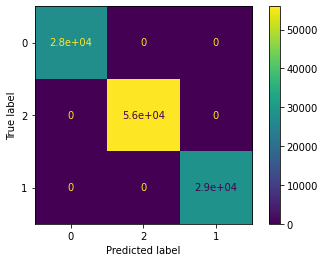

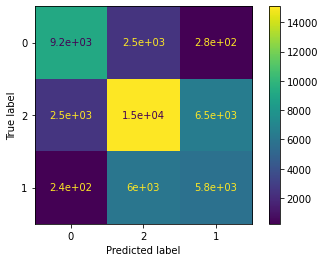

In [ ]:
# Predict labels for training and test data using newly-trained decision tree classifier. Call them yhat_train and yhat_test.
yhat_train = dtree.predict(X_train)
yhat_test = dtree.predict(X_test)
Evaluate_DT(dtree, X_train, y_train, yhat_train, X_test, y_test, yhat_test, Context = '--- Decision Tree Evaluation ---')

###Finding optimized hyperparameters using randomsearch

In [ ]:
# first check the stability of our model
# the more unstable model is, the more likely will benefit from tuning hyperparameters
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# set-up the KFold constructor
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

cross_val = cross_val_score(dtree, X_train, y_train, cv=kfold, scoring='accuracy')
print(cross_val.mean())


0.6256325483518643


In [ ]:
#optimize parameters with randomsearch
from sklearn.model_selection import RandomizedSearchCV

#create constructor
params = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [2, 3, 4, 5, 6],'max_depth': list(range(1,21)),'min_samples_leaf': list(range(1,10))}
random = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=params, verbose=1, cv=3 )
rand_search_cv = random.fit(X_train, y_train)
print("Best params: ", rand_search_cv.best_params_)
print("Best estimators: ", rand_search_cv.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.4s finished


Best params:  {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_leaf_nodes': 8, 'max_depth': 13}
Best estimators:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=13, max_features=None, max_leaf_nodes=8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


In [ ]:
# let's now run the model again with the optimized parameters
# Notice that every time you run the randomized optimizer will  generate different results

dtree2 = DecisionTreeClassifier(min_samples_split=4, max_leaf_nodes=9, max_depth=6, min_samples_leaf=7 , criterion='gini',splitter='best', random_state = 42)
dtree2.fit(X_train, y_train)
print("Accuracy of train dataset: {:.3f}".format(dtree2.score(X_train, y_train)))
print("Accuracy of test dataset: {:.3f}".format(dtree2.score(X_test, y_test)))

Accuracy of train dataset: 0.603
Accuracy of test dataset: 0.603


# Ensemble model - Random Forest QuAMs
Random forest is a ensemble of decision trees which aims to improve prediction accuracy while avoiding over fitting. <br>

In sklearn's Random forest implementation, each subsample used to fit each tree is same size as actual data but sampled using replacement if <b>bootstrap </b> hyperparameter is set to True. It has many hyperparameters similar to decision tree. <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">sklearn documenatation </a>

###Model1

In [ ]:
rf1 = RandomForestClassifier()
rf1.fit(X_train,y_train)
yhat_train_rf1 = rf1.predict(X_train)
yhat_test_rf1 = rf1.predict(X_test)

print("Train data f1 score: ", f1_score(y_train,yhat_train_rf1,average=None))
print("Test data f1 score: ", f1_score(y_test,yhat_test_rf1,average=None))

Train data f1 score:  [1. 1. 1.]
Test data f1 score:  [0.84278205 0.54053293 0.74319089]


In [ ]:
rf1_dt=rf1.estimators_[0]

In [ ]:
rf1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

With default setting, we see that the model has better performance on test data but the training data f1 score is very high, signifying a overfitting. 

### Model 2
1. Using max_depth = 15
2. Class_weight = "balanced_subsample" - Same as balanced but the ratio is computed for each tree based on the bootstrapped data considered

In [ ]:
rf2=RandomForestClassifier(max_depth=15,class_weight="balanced_subsample")
rf2.fit(X_train,y_train)
yhat_train_rf2 = rf2.predict(X_train)
yhat_test_rf2 = rf2.predict(X_test)

print("Train data f1 score: ", f1_score(y_train,yhat_train_rf2,average=None))
print("Test data f1 score: ", f1_score(y_test,yhat_test_rf2,average=None))

Train data f1 score:  [0.93557689 0.71834075 0.80848298]
Test data f1 score:  [0.84107166 0.60085903 0.69923244]


#kNN QuAMs

###kNN classifier building

###Model1

In [ ]:
kNN = KNeighborsClassifier()
kNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

--- kNN Evaluation ---
Accuracy on training data: 0.7673
Precision on training data: [0.866  0.6988 0.7524]
Recall on training data: [0.8274 0.6156 0.8147]
F1 score on training data: [0.8463 0.6546 0.7823]
Accuracy on test data: 0.6597
Precision on test data: [0.8097 0.5166 0.6532]
Recall on test data: [0.7677 0.4573 0.7076]
F1 score on test data: [0.7881 0.4851 0.6793]
---------------------


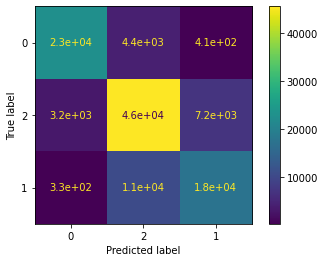

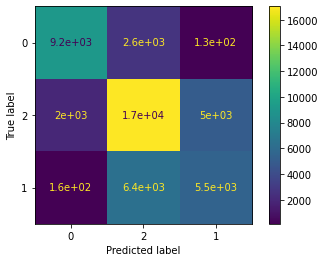

In [ ]:
yhat_test = kNN.predict(X_test)
yhat_train = kNN.predict(X_train)
Evaluate_KNN(kNN, X_train, y_train, yhat_train, X_test, y_test, yhat_test, Context = '--- kNN Evaluation ---')

###Model2

###Finding optimal k value(n_neighbors)

In [ ]:
accuracy = []
neighbors = list(range(1,60))
train_results = []
test_results = []
for n in neighbors:    
    kNN = KNeighborsClassifier (n_neighbors=n)
    kNN.fit(X_train,y_train)
    pred_i = kNN.predict(X_test)
    accuracy.append(metrics.accuracy_score(pred_i,y_test))

In [ ]:
import plotly.graph_objects as go

x = list(range(1,60))

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=accuracy,
    mode='lines+markers'
))
fig.show()

From the above graph, we can see that the accuracy is highest when n = 58. Let's run our model again

In [ ]:
kNN = KNeighborsClassifier(n_neighbors=58)
kNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=58, p=2,
                     weights='uniform')

--- kNN Evaluation ---
Accuracy on training data: 0.7129
Precision on training data: [0.8682 0.6522 0.6752]
Recall on training data: [0.7593 0.4512 0.8231]
F1 score on training data: [0.8101 0.5334 0.7418]
Accuracy on test data: 0.699
Precision on test data: [0.8617 0.6129 0.6658]
Recall on test data: [0.752  0.4292 0.808 ]
F1 score on test data: [0.8031 0.5048 0.73  ]
---------------------


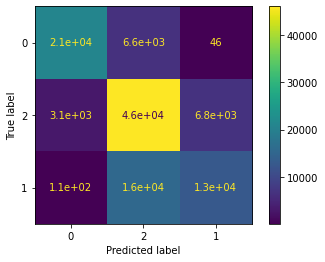

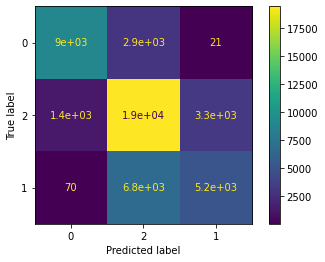

In [ ]:
yhat_test = kNN.predict(X_test)
yhat_train = kNN.predict(X_train)
Evaluate_KNN(kNN, X_train, y_train, yhat_train, X_test, y_test, yhat_test, Context = '--- kNN Evaluation ---')

###Model3

###Normalize the splitted data for building kNN

In [ ]:
min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)
y_train_norm = y_train
y_test_norm = y_train

In [ ]:
kNN = KNeighborsClassifier(n_neighbors=58)
kNN.fit(X_train_norm, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=58, p=2,
                     weights='uniform')

--- kNN Evaluation ---
Accuracy on training data: 0.7291
Precision on training data: [0.8975 0.6537 0.6929]
Recall on training data: [0.7763 0.4968 0.8239]
F1 score on training data: [0.8325 0.5645 0.7528]
Accuracy on test data: 0.714
Precision on test data: [0.8558 0.6395 0.6794]
Recall on test data: [0.804  0.4198 0.8169]
F1 score on test data: [0.8291 0.5069 0.7419]
---------------------


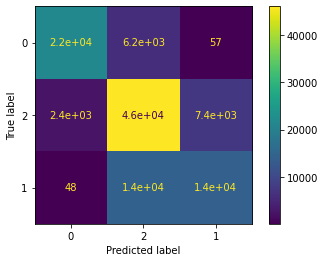

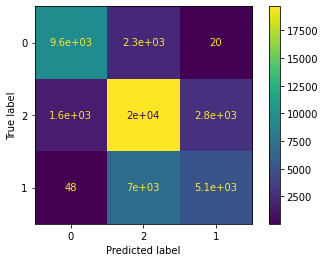

In [ ]:
yhat_test_norm = kNN.predict(X_test_norm)
yhat_train_norm = kNN.predict(X_train_norm)
Evaluate_KNN(kNN, X_train_norm, y_train, yhat_train_norm, X_test_norm, y_test, yhat_test_norm, Context = '--- kNN Evaluation ---')

#Linear Regression QuAMs

In [ ]:
fig = px.scatter(engine_df2, x='Time_in_Cycles', y='RUL', color='OP_Condition')
fig.show()

In [ ]:
LR_dropped_features = ['Unit_Number', 'Time_in_Cycles','OP_Setting_2', 'OP_Setting_3',
                    'T2', 'P2', 'P15', 'phi', 'BPR', 'Nf_dmd', 'PCNfR_dmd', 'NRf', 'Engine_Type',
                    'Engine_Lifetime', 'rho2', 'v_sound', 'u2', 'Nf', 'T24',
                    'T30', 'Risk_Level', 'OP_Condition', 'mdot_2', 'Fuel_flow', 'NRc', 'eLPC']

is_high_risk = (engine_df2.loc[:,'Risk_Level'] == 'High')
engine_df4 = Drop_Features(engine_df2, LR_dropped_features).loc[is_high_risk,:]

Dropped Unit_Number
Dropped Time_in_Cycles
Dropped OP_Setting_2
Dropped OP_Setting_3
Dropped T2
Dropped P2
Dropped P15
Dropped phi
Dropped BPR
Dropped Nf_dmd
Dropped PCNfR_dmd
Dropped NRf
Dropped Engine_Type
Dropped Engine_Lifetime
Dropped rho2
Dropped v_sound
Dropped u2
Dropped Nf
Dropped T24
Dropped T30
Dropped Risk_Level
Dropped OP_Condition
Dropped mdot_2
Dropped Fuel_flow
Dropped NRc
Dropped eLPC


In [ ]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import PowerTransformer

In [ ]:
normer = MinMaxScaler()
X_LR = engine_df4.drop('RUL', axis=1)
X_LR_norm = pd.DataFrame(normer.fit_transform(X_LR), index = X_LR.index, columns = X_LR.columns)
y_LR = engine_df4.loc[:,'RUL']
X_LR.head()

OP_Setting_1      T50     P30  ...  mdot_fan  mdot_core      eHPC
135       -0.0011  1405.15  553.39  ...  0.000000   0.000000  0.597144
136       -0.0011  1413.34  552.91  ...  0.023652   0.000334  0.595684
137       -0.0014  1412.60  553.25  ...  0.118839   0.001660  0.596107
138       -0.0006  1408.36  552.15  ...  0.000000   0.000000  0.595792
139       -0.0023  1415.25  553.45  ...  0.118867   0.001659  0.595986

[5 rows x 13 columns]

In [ ]:
y_LR.describe()

count    39704.000000
mean        27.500000
std         16.163433
min          0.000000
25%         13.750000
50%         27.500000
75%         41.250000
max         55.000000
Name: RUL, dtype: float64

In [ ]:
Xtrain_LR, Xtest_LR, ytrain_LR, ytest_LR = train_test_split(X_LR, y_LR, test_size=0.8, random_state = 42)

In [ ]:
print(pd.Series(data=ytrain_LR).describe())
pd.Series(data=ytest_LR).describe()

count    7940.000000
mean       27.619395
std        16.133098
min         0.000000
25%        14.000000
50%        28.000000
75%        42.000000
max        55.000000
Name: RUL, dtype: float64


count    31764.000000
mean        27.470155
std         16.171123
min          0.000000
25%         13.000000
50%         27.000000
75%         41.000000
max         55.000000
Name: RUL, dtype: float64

In [ ]:
Reg1 = LinearRegression()
Reg1.fit(Xtrain_LR, ytrain_LR)
Evaluate_Reg(Reg1, Xtest_LR, ytest_LR)

Mean absolute error = 11.2
Mean Squared Error = 184.8
Root Mean Squared Error = 13.6
Coefficient of determination = 0.29


In [ ]:
y_pred1 = Reg1.predict(Xtrain_LR)
pd.Series(y_pred1).describe()

count    7940.000000
mean       27.619395
std         8.696125
min        -5.777255
25%        21.585077
50%        27.445675
75%        33.405591
max        55.935867
dtype: float64

In [ ]:
def Tune_alpha(Regressor, X_train, y_train, X_validation, y_validation):
  best_r2_score = -np.infty
  best_alpha = np.nan
  for alpha in np.logspace(-3, 0, 50):
    reg = Regressor(alpha=alpha)
    reg.fit(X_train, y_train)
    yhat_validation = reg.predict(X_validation)
    this_r2_score = r2_score(y_validation, yhat_validation)
    
    #print("Regularization coefficient:", alpha)
    yhat_train = reg.predict(X_train)
    #print("\tR2 score on training data is", r2_score(y_train, yhat_train))
    #print("\tR2 score on validation data is", this_r2_score)
    if  this_r2_score > best_r2_score:
      best_r2_score = this_r2_score
      best_alpha = alpha
  print("Best alpha found is", best_alpha)
  print("Best r2 score for this alpha is", best_r2_score)

  return best_alpha

In [ ]:
Reg2 = Ridge(alpha = Tune_alpha(Ridge, Xtrain_LR, ytrain_LR, Xtest_LR, ytest_LR))
Reg2.fit(Xtrain_LR, ytrain_LR)
Evaluate_Reg(Reg2, Xtest_LR, ytest_LR)

Best alpha found is 0.001
Best r2 score for this alpha is 0.29259696899972
Mean absolute error = 11.2
Mean Squared Error = 185.0
Root Mean Squared Error = 13.6
Coefficient of determination = 0.29


In [ ]:
y_pred2 = Reg2.predict(Xtrain_LR)
pd.Series(y_pred2).describe()

count    7940.000000
mean       27.619395
std         8.563734
min        -5.310639
25%        21.664960
50%        27.421129
75%        33.277671
max        55.339755
dtype: float64

In [ ]:
Reg3 = Lasso(alpha = Tune_alpha(Lasso, Xtrain_LR, ytrain_LR, Xtest_LR, ytest_LR))
Reg3.fit(Xtrain_LR, ytrain_LR)
Evaluate_Reg(Reg3, Xtest_LR, ytest_LR)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 783068.1952019731, tolerance: 206.63378130982375

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 786466.910383136, tolerance: 206.63378130982375

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 790248.6050124938, tolerance: 206.63378130982375

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 794427.8604355054, tolerance: 206.63378

Best alpha found is 0.001
Best r2 score for this alpha is 0.26477861427823546
Mean absolute error = 11.5
Mean Squared Error = 192.3
Root Mean Squared Error = 13.9
Coefficient of determination = 0.26


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 783068.1952019731, tolerance: 206.63378130982375



In [ ]:
y_pred3 = Reg3.predict(Xtrain_LR)
pd.Series(y_pred3).describe()

count    7940.000000
mean       27.619395
std         7.964872
min        -0.370088
25%        21.929695
50%        27.362359
75%        33.028300
max        53.943706
dtype: float64

In [ ]:
feature_weights = pd.DataFrame(X_LR.columns, columns=['feature_name'])
feature_weights['LR_weight'] = Reg1.coef_
feature_weights['Ridge_weight'] = Reg2.coef_
feature_weights['Lasso_weight'] = Reg3.coef_
fig1 = px.bar(feature_weights, x='feature_name', y='LR_weight', color='LR_weight', color_discrete_sequence='Temps')
fig2 = px.bar(feature_weights, x='feature_name', y='Ridge_weight', color='Ridge_weight', color_discrete_sequence='Temps')
fig3 = px.bar(feature_weights, x='feature_name', y='Lasso_weight', color='Lasso_weight', color_discrete_sequence='Temps')
fig1.show()
fig2.show()
fig3.show()

In [ ]:
feature_weights

feature_name    LR_weight  Ridge_weight  Lasso_weight
0   OP_Setting_1     4.592528      4.555555      4.953868
1            T50    -0.226899     -0.223652     -0.166013
2            P30    -1.332069     -1.331129      0.555851
3             Nc    -0.023794     -0.023711     -0.027555
4            epr   248.527379    240.088867    343.594096
5           Ps30   -10.153439    -10.834910    -13.446654
6           farB  -353.163331   -333.995616     -0.000000
7        htBleed     1.674720      1.710634      0.729318
8            W31    14.999009     15.019880      0.071613
9            W32    17.006200     16.984711     -0.517062
10      mdot_fan    -1.623994     -1.620370     -1.337107
11     mdot_core   128.728997    128.090132    131.592883
12          eHPC -3131.741526  -2929.898612  -2696.343724

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
ereg = VotingRegressor(estimators=[('LR', Reg1), ('RI', Reg2), ('LA', Reg3)])
ereg.fit(Xtrain_LR, ytrain_LR)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 783068.1952019731, tolerance: 206.63378130982375



VotingRegressor(estimators=[('LR',
                             LinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False)),
                            ('RI',
                             Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001)),
                            ('LA',
                             Lasso(alpha=0.001, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False, precompute=False,
                                   random_state=None, selection='cyclic',
                                   tol=0.0001, warm_start=False))],
                n_jobs=None, weights=None)

In [ ]:
y_pred4 = ereg.predict(Xtrain_LR)
pd.Series(y_pred4).describe()

count    7940.000000
mean       27.619395
std         8.332196
min        -3.819327
25%        21.776445
50%        27.404065
75%        33.272511
max        54.645349
dtype: float64

In [ ]:
Evaluate_Reg(ereg, Xtest_LR, ytest_LR)

Mean absolute error = 11.3
Mean Squared Error = 185.9
Root Mean Squared Error = 13.6
Coefficient of determination = 0.29


In [ ]:
yhat = pd.Series(ereg.predict(X_LR), index=y_LR.index, name='yhat')
yhat

135      30.496142
136      38.573567
137      35.566037
138      38.002218
139      37.389096
           ...    
61243    27.663046
61244    27.007733
61245    20.476231
61246    36.356066
61247    22.716489
Name: yhat, Length: 39704, dtype: float64

In [ ]:
LR_results = engine_df2.copy().loc[is_high_risk, :]
LR_results['RUL_residuals'] = y_LR - yhat

fig = px.scatter(LR_results, x='RUL', y='RUL_residuals',
                 color='OP_Condition', 
                 marginal_y = 'violin')
fig.show()

In [ ]:
def Evaluate_Reg_results(y_pred, y_true):
  MAE = metrics.mean_absolute_error(y_true=y_true, y_pred=y_pred)
  MSE = metrics.mean_squared_error(y_true,y_pred)
  RMSE = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
  CoD = metrics.r2_score(y_true,y_pred)

  print(f'Mean absolute error = {MAE:.1f}')
  print(f'Mean Squared Error = {MSE:.1f}')
  print(f'Root Mean Squared Error = {RMSE:.1f}')
  print(f'Coefficient of determination = {CoD:.2f}')

In [ ]:
Evaluate_Reg_results(yhat,y_LR)

Mean absolute error = 11.3
Mean Squared Error = 185.8
Root Mean Squared Error = 13.6
Coefficient of determination = 0.29
